## Credit Card Fraud Case Study

### Importing basic modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import HalvingRandomSearchCV,RandomizedSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

seed = 39

train = pd.read_csv('../input/fraud-detection/fraudTrain.csv')
test = pd.read_csv('../input/fraud-detection/fraudTest.csv')
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### Importing Data

In [2]:
print(test.shape),print(train.shape)
print(test.isnull().sum())
print(train.isnull().sum())
print(test.info(), train.info())

(555719, 23)
(1296675, 23)
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip            

### Data Cleaning 

Converting dob,trans_date_trans_time  column in both test & train to datetime data type and creating new 'trans_date' column - 

In [3]:
train['trans_date_trans_time']=pd.to_datetime(train['trans_date_trans_time'])
train['trans_date']=train['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
train['trans_date']=pd.to_datetime(train['trans_date'])
train['dob']=pd.to_datetime(train['dob'])

test['trans_date_trans_time']=pd.to_datetime(test['trans_date_trans_time'])
test['trans_date']=test['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
test['trans_date']=pd.to_datetime(test['trans_date'])
test['dob']=pd.to_datetime(test['dob'])
test.trans_date.head(),test.dob.head(),train.trans_date.head(),train.dob.head()

train.drop("Unnamed: 0",axis=1,inplace=True)
test.drop("Unnamed: 0",axis=1,inplace=True)
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01


Removing unnamed column

### EDA, Feature Engineering

### Categorical Variable Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time             

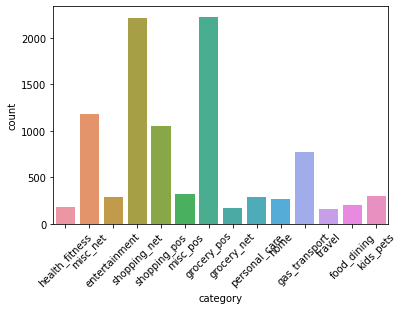

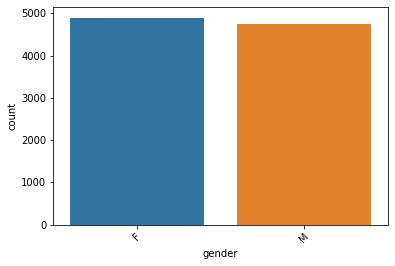

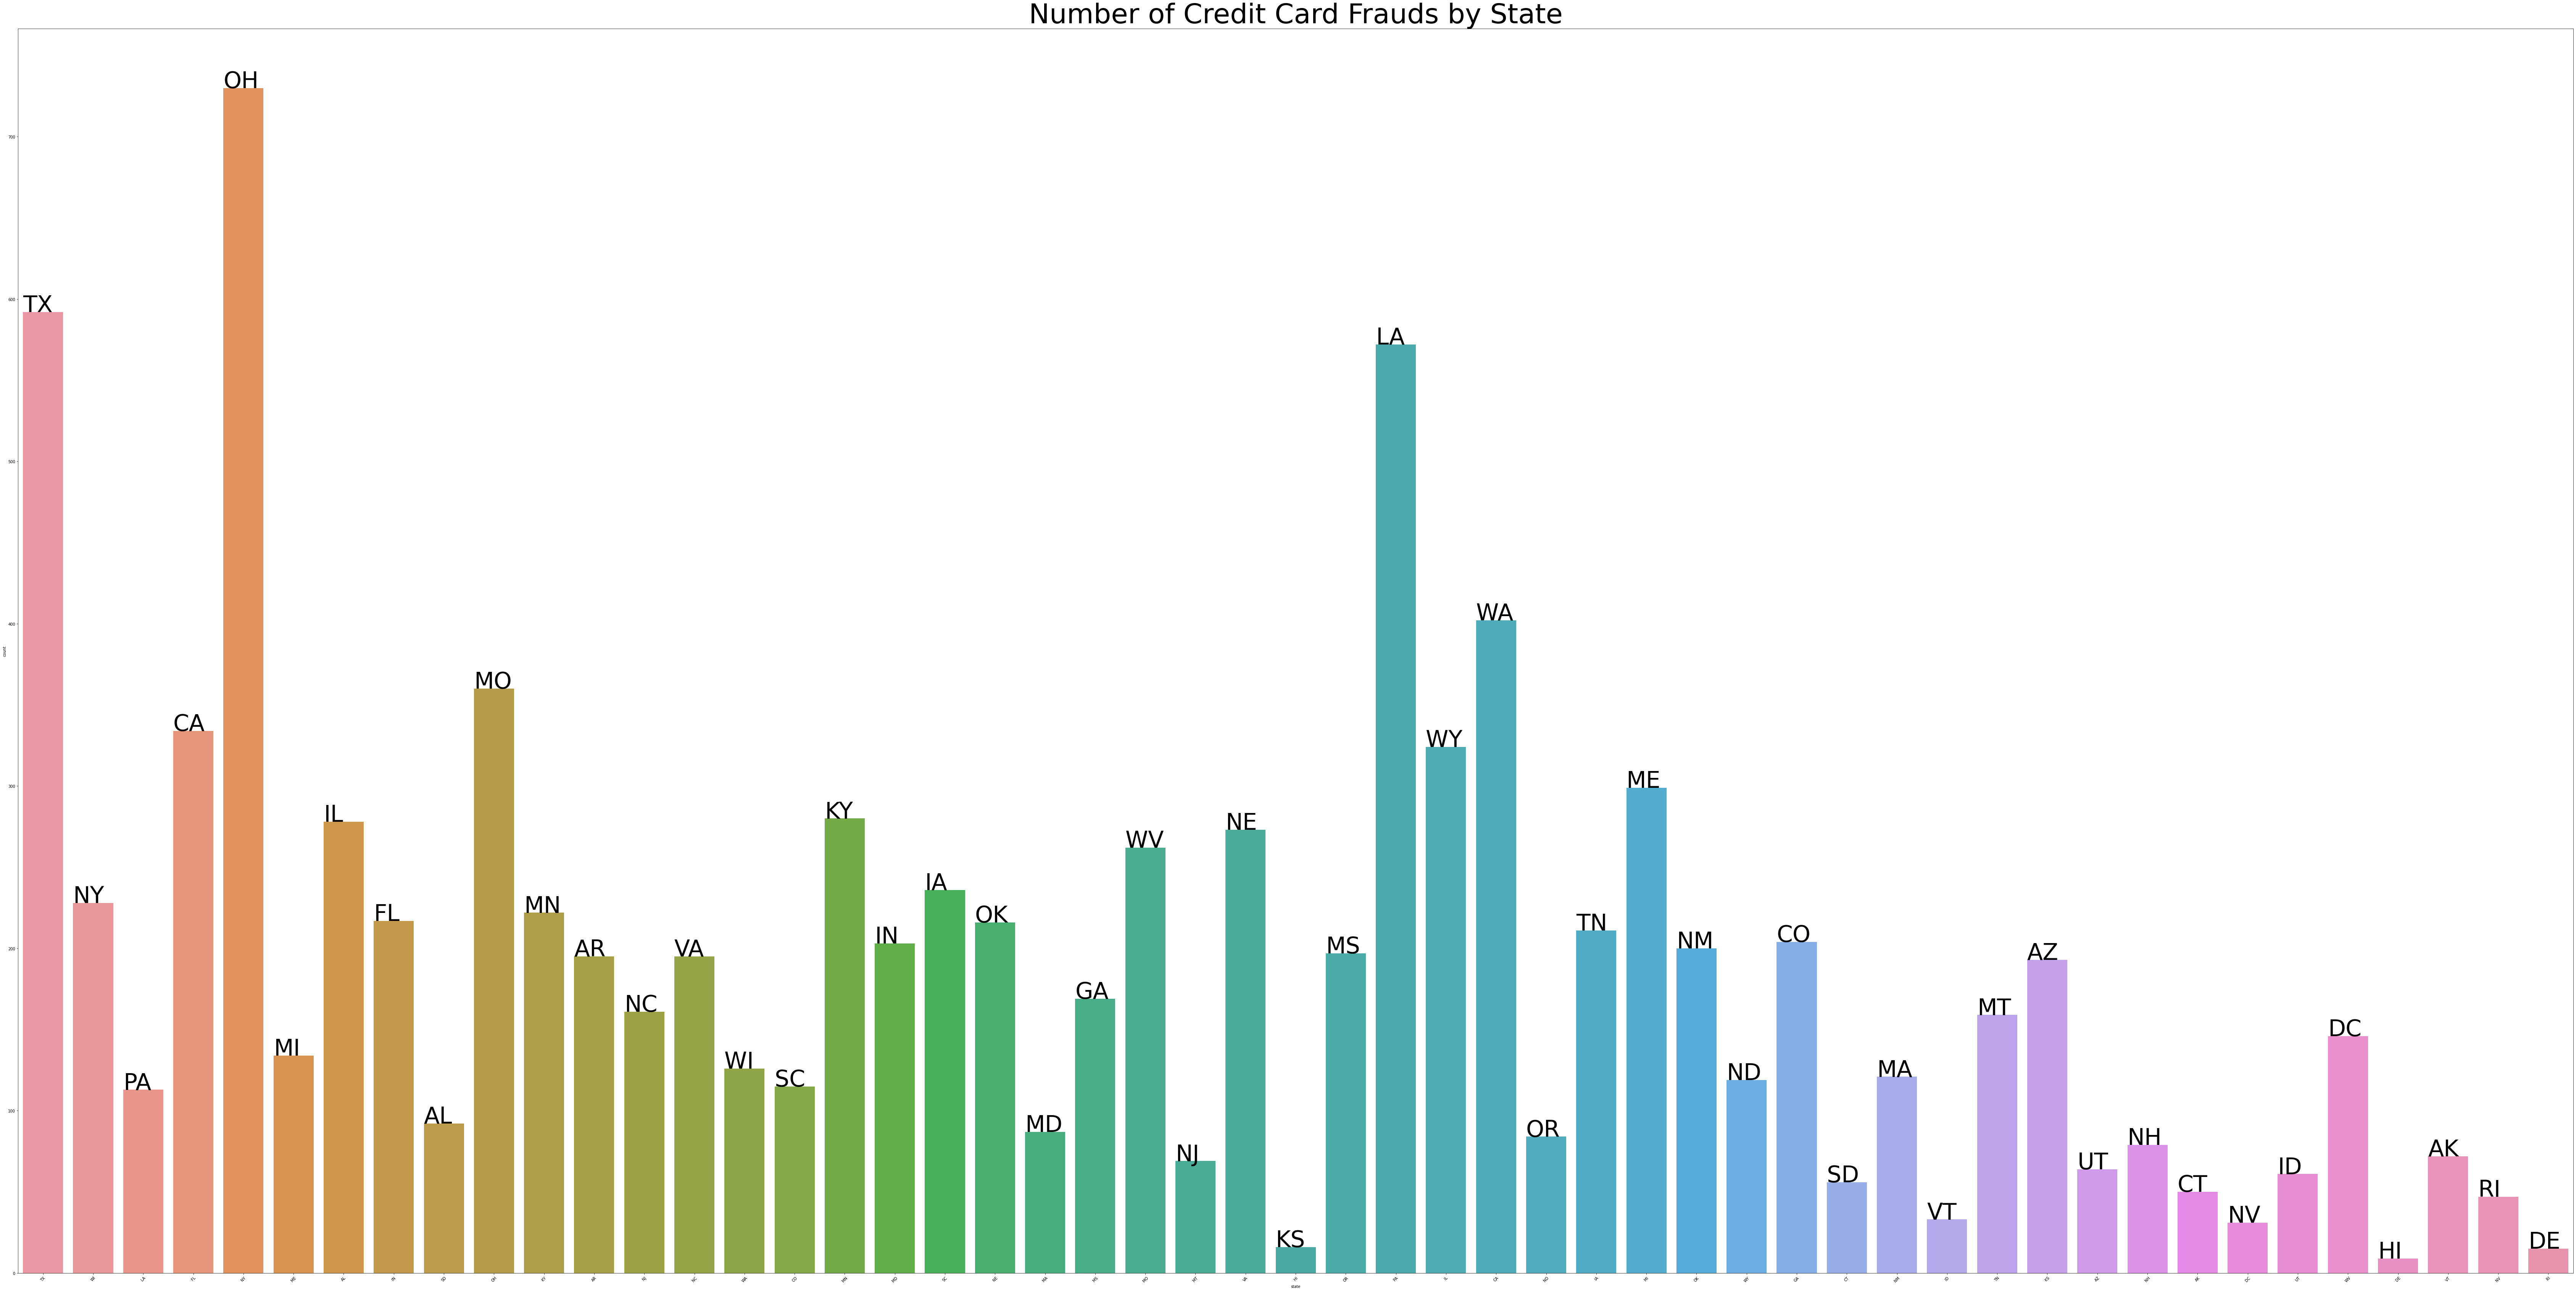

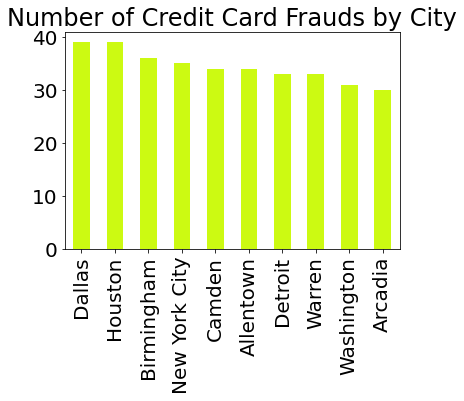

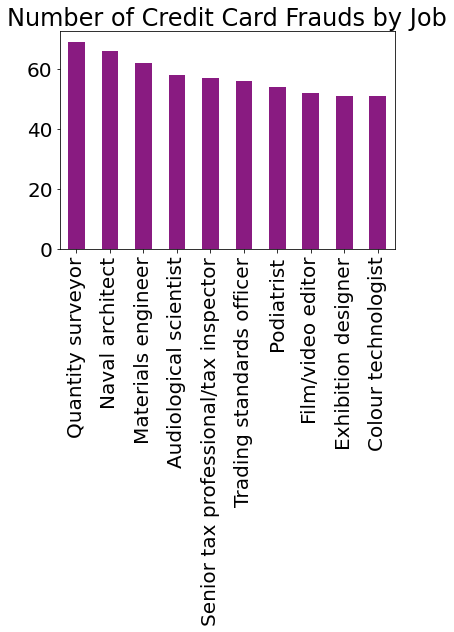

In [4]:
total = pd.concat([test,train])
print(total.info())

total["is_fraud_cat"]=total.is_fraud.apply(lambda x: "T" if x==1 else "F")
total["is_fraud_cat"].astype("object")

totalcat=total.select_dtypes(include=['object'])

total[totalcat.columns]

sns.countplot(total[total['is_fraud_cat']=="T"].category)
plt.xticks(rotation=45)
plt.show()

sns.countplot(total[total['is_fraud_cat']=="T"].gender)
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(120,60))
plt.rcParams.update({'font.size': 60})
sns.countplot(total[total['is_fraud_cat']=="T"].state)
plt.xticks(rotation=45)
for p, label in zip(ax.patches, total["state"].value_counts().index):
    ax.annotate(label, (p.get_x(), p.get_height()+0.15))
plt.title("Number of Credit Card Frauds by State")
plt.show()

import random
def randomcolor():
    r = random.random()
    b = random.random()
    g = random.random()
    rgb = [r,g,b]
    return rgb
plt.rcParams.update({'font.size': 20})
total[total['is_fraud_cat']=="T"]["city"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color=randomcolor())
plt.title("Number of Credit Card Frauds by City")
plt.show()

total[total['is_fraud_cat']=="T"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color=randomcolor())
plt.title("Number of Credit Card Frauds by Job")
plt.show()

### Numerical Variable Analysis
checking the spread & skewness of all numerical variables

In [5]:
del total['is_fraud_cat']
from scipy.stats import norm, skew

#finding numerical columns
testnum= test.select_dtypes(include=np.number)
test[testnum.columns]

# total.isnull().sum()

# total[testnum.columns].info()

# plt.rcParams.update({'font.size': 10})
# skewness = str(skew(total['amt']))
# sns.distplot(total['amt'],fit = norm,color = randomcolor())
# plt.title("Skewness of amt"+" = "+skewness)
# plt.show()

# skewness = str(skew(total['city_pop']))
# sns.distplot(total['city_pop'],fit = norm,color = randomcolor())
# plt.title("Skewness of population"+" = "+skewness)
# plt.show()

# sns.distplot(total['is_fraud'],fit = norm,color = randomcolor())
# plt.title("Distribution of is_fraud")
# plt.show()

total.drop(['cc_num','merchant','first','last','street','zip','trans_num','unix_time'],axis=1,inplace=True)
# total.info()

# plt.figure(figsize=(8,5))
# ax = sns.countplot(x="is_fraud", data=total,color=randomcolor())
# for p in ax.patches:
#      ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
# plt.show()

total["age"] = total["trans_date"]-total["dob"]
total["age"]=total["age"].astype('timedelta64[Y]')
print(total["age"].head())
# print(total.info())

fraud=total[total["is_fraud"]==1]
# fig, ax = plt.subplots()
# ax.hist(fraud.age, edgecolor = "black", bins = 5, color=randomcolor())
# plt.title("Number of Credit Card Frauds by Age Groups")
# plt.show()

total['trans_month'] = pd.DatetimeIndex(total['trans_date']).month
total['trans_year'] = pd.DatetimeIndex(total['trans_date']).year

import calendar
total['Month_name'] = total['trans_month'].apply(lambda x: calendar.month_abbr[x])

# sns.countplot(total[total["is_fraud"]==1]["Month_name"],color=randomcolor())
# plt.title("Number of Credit Card Frauds by month")
# plt.show()
del total['Month_name']

# sns.countplot(total[total["is_fraud"]==1]["gender"],color=randomcolor())
# plt.title("Number of Credit Card Frauds by Gender")
# plt.show()

# sns.countplot(total[total["is_fraud"]==1]["trans_year"],color=randomcolor())
# plt.title("Number of Credit Card Frauds by year")
# plt.show()

total['latitudinal_distance'] = abs(round(total['merch_lat']-total['lat'],3))
total['longitudinal_distance'] = abs(round(total['merch_long']-total['long'],3))

fraud = total[total["is_fraud"]==1]
# fig, ax = plt.subplots()
# ax.hist(fraud.latitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
# plt.title("Number of Credit Card Frauds by latitudinal distance")
# plt.show()

# fig, ax = plt.subplots()
# ax.hist(fraud.longitudinal_distance, edgecolor = "black", bins = 5, color=randomcolor())
# plt.title("Number of Credit Card Frauds by longitudinal distance")
# plt.show()

# print(total.info())

# print(total.gender.value_counts())

total.gender=total.gender.apply(lambda x: 1 if x=="M" else 0)
total.gender.value_counts()

drop_cols = ['trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long','trans_date','state']
total=total.drop(drop_cols,axis=1)
# total.info()

total = pd.get_dummies(total,columns=['category'],drop_first=True)
print(total.info())
total.head()

0    52.0
1    30.0
2    49.0
3    32.0
4    64.0
Name: age, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   int64  
 2   city_pop                 int64  
 3   is_fraud                 int64  
 4   age                      float64
 5   trans_month              int64  
 6   trans_year               int64  
 7   latitudinal_distance     float64
 8   longitudinal_distance    float64
 9   category_food_dining     uint8  
 10  category_gas_transport   uint8  
 11  category_grocery_net     uint8  
 12  category_grocery_pos     uint8  
 13  category_health_fitness  uint8  
 14  category_home            uint8  
 15  category_kids_pets       uint8  
 16  category_misc_net        uint8  
 17  category_misc_pos        uint8  
 18  category_personal_care   uint8  
 19  category

,amt,gender,city_pop,is_fraud,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_food_dining,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2.86,1,333497,0,52.0,6,2020,0.020,0.265,0,...,0,0,0,0,0,0,1,0,0,0
1,29.84,0,302,0,30.0,6,2020,0.870,0.476,0,...,0,0,0,0,0,0,1,0,0,0
2,41.28,0,34496,0,49.0,6,2020,0.177,0.660,0,...,0,1,0,0,0,0,0,0,0,0
3,60.05,1,54767,0,32.0,6,2020,0.243,0.064,0,...,0,0,0,0,0,1,0,0,0,0
4,3.19,1,1126,0,64.0,6,2020,0.706,0.868,0,...,0,0,0,0,0,0,0,0,0,1


Dropping final set of variables not useful for model building

### Model Building

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = total[(total['is_fraud']==0)] 
df_minority = total[(total['is_fraud']==1)] 

df_majority.shape,df_minority.shape

((1842743, 22), (9651, 22))

# Method 0: No sampling (BASELINE)

In [7]:
x_train_ori_col = list(total.columns)
x_train_ori_col.remove('is_fraud')
x_train_ori_col

X_ori = total[x_train_ori_col]
Y_ori = total['is_fraud']
print(X_ori.info())

X_train_ori, X_test_ori, Y_train_ori, Y_test_ori = train_test_split(
 X_ori, Y_ori, test_size=0.3, random_state=seed)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   int64  
 2   city_pop                 int64  
 3   age                      float64
 4   trans_month              int64  
 5   trans_year               int64  
 6   latitudinal_distance     float64
 7   longitudinal_distance    float64
 8   category_food_dining     uint8  
 9   category_gas_transport   uint8  
 10  category_grocery_net     uint8  
 11  category_grocery_pos     uint8  
 12  category_health_fitness  uint8  
 13  category_home            uint8  
 14  category_kids_pets       uint8  
 15  category_misc_net        uint8  
 16  category_misc_pos        uint8  
 17  category_personal_care   uint8  
 18  category_shopping_net    uint8  
 19  category_shopping_pos    uint8  
 20  category_travel          uint8  
dtypes: float

In [8]:
sc= StandardScaler()
X_train_ori_std=sc.fit_transform(X_train_ori)
X_test_ori_std = sc.fit_transform(X_test_ori)

In [9]:
dtc_no_sampling = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)
dtc_no_sampling.fit(X_train_ori_std,Y_train_ori)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [10]:
feature= pd.DataFrame()
feature['column']= X_train_ori.columns
feature['importance']= dtc_no_sampling.feature_importances_
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,0.414382
11,category_grocery_pos,0.305827
9,category_gas_transport,0.103044
3,age,0.059949
16,category_misc_pos,0.021629
1,gender,0.020805
2,city_pop,0.019243
18,category_shopping_net,0.011155
15,category_misc_net,0.008099
20,category_travel,0.007680


In [11]:
print("Score of the model with X-train and Y-train is : ", str(round(dtc_no_sampling.score(X_train_ori,Y_train_ori)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(dtc_no_sampling.score(X_test_ori,Y_test_ori)*100,2)),"%")

Y_pred_ori=dtc_no_sampling.predict(X_test_ori_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test_ori,Y_pred_ori)))
print(" Mean squared  error is " , mean_squared_error(Y_test_ori,Y_pred_ori))
print(" Median absolute error is " ,median_absolute_error(Y_test_ori,Y_pred_ori)) 
print("Accuracy is " , round(accuracy_score(Y_test_ori,Y_pred_ori)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test_ori, Y_pred_ori, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test_ori, Y_pred_ori, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  94.14 %
Score of the model with X-test and Y-test is :  94.14 %
 Mean absolute error is  0.0027100027172005997
 Mean squared  error is  0.0027100027172005997
 Median absolute error is  0.0
Accuracy is  99.73 %
F1 score:  85.9 %
Recall: 83.59 %


## FIND important feature based on original data distribution

In [12]:
logit_model_no_sampling = LogisticRegression(solver='liblinear')
logit_model_no_sampling.fit(X_train_ori_std, Y_train_ori)

LogisticRegression(solver='liblinear')

In [13]:
feature= pd.DataFrame()
feature['column']= X_train_ori.columns
feature['importance']= logit_model_no_sampling.coef_[0]
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
11,category_grocery_pos,0.484821
0,amt,0.431627
18,category_shopping_net,0.425063
15,category_misc_net,0.341975
9,category_gas_transport,0.197517
3,age,0.186389
19,category_shopping_pos,0.168489
1,gender,0.105652
10,category_grocery_net,0.056357
16,category_misc_pos,0.041955


## Train and Finetuning

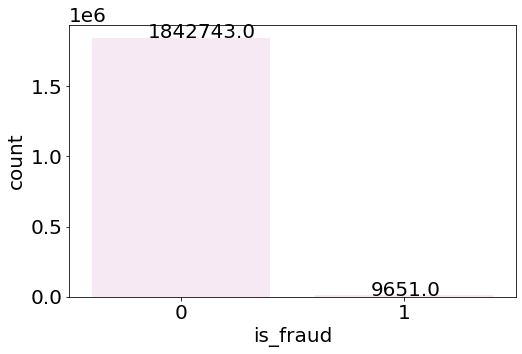

In [14]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x="is_fraud", data=total,color=randomcolor())
for p in ax.patches:
     ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

`X_train_ori, X_test_ori, Y_train_ori, Y_test_ori`

In [15]:
Logit1_ori=LogisticRegression(solver='liblinear')

Logit1_ori.fit(X_train_ori_std,Y_train_ori)

print("Score of the model with X-train and Y-train is : ", str(round(Logit1_ori.score(X_train_ori,Y_train_ori)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit1_ori.score(X_test_ori,Y_test_ori)*100,2)),"%")

Y_pred_ori=Logit1_ori.predict(X_test_ori_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test_ori,Y_pred_ori)))
print(" Mean squared  error is " , mean_squared_error(Y_test_ori,Y_pred_ori))
print(" Median absolute error is " ,median_absolute_error(Y_test_ori,Y_pred_ori)) 
print("Accuracy is " , round(accuracy_score(Y_test_ori,Y_pred_ori)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test_ori, Y_pred_ori, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test_ori, Y_pred_ori, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  76.91 %
Score of the model with X-test and Y-test is :  76.93 %
 Mean absolute error is  0.005671931317806301
 Mean squared  error is  0.005671931317806301
 Median absolute error is  0.0
Accuracy is  99.43 %
F1 score:  49.86 %
Recall: 49.97 %


In [16]:
DTC1_ori=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC1_ori.fit(X_train_ori_std,Y_train_ori)

print("Score of the model with X-train and Y-train is : ", str(round(DTC1_ori.score(X_train_ori,Y_train_ori)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(DTC1_ori.score(X_test_ori,Y_test_ori)*100,2)),"%")

Y_pred_ori=DTC1_ori.predict(X_test_ori_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test_ori,Y_pred_ori)))
print(" Mean squared  error is " , mean_squared_error(Y_test_ori,Y_pred_ori))
print(" Median absolute error is " ,median_absolute_error(Y_test_ori,Y_pred_ori)) 
print("Accuracy is " , round(accuracy_score(Y_test_ori,Y_pred_ori)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test_ori, Y_pred_ori, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test_ori, Y_pred_ori, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  94.14 %
Score of the model with X-test and Y-test is :  94.14 %
 Mean absolute error is  0.0027046043054133476
 Mean squared  error is  0.0027046043054133476
 Median absolute error is  0.0
Accuracy is  99.73 %
F1 score:  85.92 %
Recall: 83.57 %


In [17]:
X_train_ori_new = X_train_ori[[x for x in feature[feature["importance"]>0].column]]
X_test_ori_new = X_test_ori[[x for x in feature[feature["importance"]>0].column]]

In [18]:
X_train_ori_sm = sm.add_constant(X_train_ori_new)
logm = sm.GLM(Y_train_ori, X_train_ori_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_fraud   No. Observations:              1296675
Model:                            GLM   Df Residuals:                  1296661
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36376.
Date:                Wed, 10 Apr 2024   Deviance:                       72752.
Time:                        08:05:46   Pearson chi2:                 3.17e+16
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009228
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.3128      0.057   -129.243      0.000      -7.424      -7.202
category_grocery_pos       2.1011      0.044     48.174      0.000       2.016       2.187
amt                        0.0022   2.96e-05     75.360      0.000       0.002       0.002
category_shopping_net      2.1633      0.045     48.417      0.000       2.076       2.251
category_misc_net          2.0780      0.050     41.256      0.000       1.979       2.177
category_gas_transport     1.0761      0.056     19.275      0.000       0.967       1.186
age                        0.0100      0.001     14.208      0.000       0.009       0.011
category_shopping_pos      1.1821      0.053     22.128      0.000       1.077       1.287
gender                     0.2023      0.025      7.979      0.000       0.153       0.252
category_grocery_net       0.7168      0.099      7.212      0.000       0.522       0.912
category_misc_pos          0.6550      0.075      8.687      0.000       0.507       0.803
category_personal_care     0.5005      0.079      6.338      0.000       0.346       0.655
latitudinal_distance       0.0284      0.044      0.646      0.518      -0.058       0.114
city_pop                4.089e-08   4.24e-08      0.965      0.334   -4.21e-08    1.24e-07
==========================================================================================
"""

In [19]:
vif = pd.DataFrame()
vif['Features'] = X_train_ori_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_ori_new.values, i) for i in range(X_train_ori_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,age,3.79
11,latitudinal_distance,3.14
7,gender,1.71
0,category_grocery_pos,1.21
4,category_gas_transport,1.21
1,amt,1.19
6,category_shopping_pos,1.17
2,category_shopping_net,1.14
10,category_personal_care,1.14
9,category_misc_pos,1.11


In [20]:
# since all columns have VIF < 5 , we'll continue with all columns
#x_train_vif_adj = X_train_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_train_ori_vif_adj = X_train_ori_new
#x_test_vif_adj = X_test_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_test_ori_vif_adj = X_test_ori_new

In [21]:
sc= StandardScaler()
X_train_ori_vif_adj_std=sc.fit_transform(x_train_ori_vif_adj)
X_test_ori_vif_adj_std = sc.fit_transform(x_test_ori_vif_adj)

In [22]:
Logit2_ori=LogisticRegression(solver='liblinear')

Logit2_ori.fit(X_train_ori_vif_adj_std,Y_train_ori)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2_ori.score(X_train_ori_vif_adj_std,Y_train_ori)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2_ori.score(X_test_ori_vif_adj_std,Y_test_ori)*100,2)),"%")

Y_pred_ori=Logit2_ori.predict(X_test_ori_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test_ori,Y_pred_ori)))
print(" Mean squared  error is " , mean_squared_error(Y_test_ori,Y_pred_ori))
print(" Median absolute error is " ,median_absolute_error(Y_test_ori,Y_pred_ori)) 
print("Accuracy is " , round(accuracy_score(Y_test_ori,Y_pred_ori)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test_ori, Y_pred_ori, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test_ori, Y_pred_ori, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  99.44 %
Score of the model with X-test and Y-test is :  99.44 %
 Mean absolute error is  0.005630543494104035
 Mean squared  error is  0.005630543494104035
 Median absolute error is  0.0
Accuracy is  99.44 %
F1 score:  49.86 %
Recall: 49.98 %


In [23]:
matrix = confusion_matrix(Y_test_ori,Y_pred_ori, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test_ori,Y_pred_ori,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test_ori,Y_pred_ori,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[     0   2870]
 [   259 552590]]
Outcome values : 
 0 2870 259 552590
Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      2870
           0       0.99      1.00      1.00    552849

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



In [24]:
m0_lg_Recall = recall_score(Y_test_ori, Y_pred_ori, average='macro')
m0_lg_Precision = precision_score(Y_test_ori, Y_pred_ori,average='macro')
m0_lg_f1 = f1_score(Y_test_ori, Y_pred_ori,average='macro')
m0_lg_accuracy = accuracy_score(Y_test_ori, Y_pred_ori)
m0_lg_mae = mean_absolute_error(Y_test_ori,Y_pred_ori)
m0_lg_mse = mean_squared_error(Y_test_ori,Y_pred_ori)

m0_ndf = [(m0_lg_Recall, m0_lg_Precision, m0_lg_f1, m0_lg_accuracy,m0_lg_mae,m0_lg_mse)]
m0_lg_score = pd.DataFrame(data = m0_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m0_lg_score.insert(0, 'Logistic Regression with', 'No Oversampling')
m0_lg_score

,Logistic Regression with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,No Oversampling,0.499766,0.497417,0.498588,0.994369,0.005631,0.005631


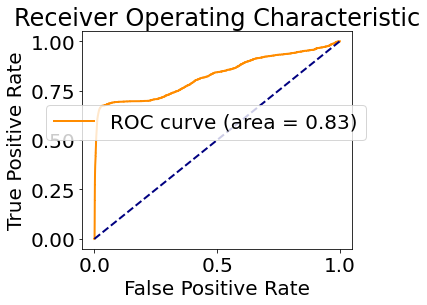

In [25]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test_ori, Logit2_ori.predict_proba(X_test_ori_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

Decision Tree

In [26]:
DTC2_ori=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC2_ori.fit(X_train_ori_vif_adj_std,Y_train_ori)

print("Score of the model with X-train and Y-train is : ", str(round(DTC2_ori.score(X_train_ori_vif_adj_std,Y_train_ori)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(DTC2_ori.score(X_test_ori_vif_adj_std,Y_test_ori)*100,2)),"%")

Y_pred_ori=DTC2_ori.predict(X_test_ori_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test_ori,Y_pred_ori)))
print(" Mean squared  error is " , mean_squared_error(Y_test_ori,Y_pred_ori))
print(" Median absolute error is " ,median_absolute_error(Y_test_ori,Y_pred_ori)) 
print("Accuracy is " , round(accuracy_score(Y_test_ori,Y_pred_ori)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test_ori, Y_pred_ori, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test_ori, Y_pred_ori, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  99.78 %
Score of the model with X-test and Y-test is :  99.73 %
 Mean absolute error is  0.002713601658392101
 Mean squared  error is  0.002713601658392101
 Median absolute error is  0.0
Accuracy is  99.73 %
F1 score:  85.65 %
Recall: 82.79 %


In [27]:
m0_dt_Recall = recall_score(Y_test_ori, Y_pred_ori, average='macro')
m0_dt_Precision = precision_score(Y_test_ori, Y_pred_ori,average='macro')
m0_dt_f1 = f1_score(Y_test_ori, Y_pred_ori,average='macro')
m0_dt_accuracy = accuracy_score(Y_test_ori, Y_pred_ori)
m0_dt_mae = mean_absolute_error(Y_test_ori,Y_pred_ori)
m0_dt_mse = mean_squared_error(Y_test_ori,Y_pred_ori)

m0_ndf = [(m0_dt_Recall, m0_dt_Precision, m0_dt_f1, m0_dt_accuracy,m0_dt_mae,m0_dt_mse)]
m0_dt_score = pd.DataFrame(data = m0_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m0_dt_score.insert(0, 'Decision Tree with', 'No Oversampling')
m0_dt_score

,Decision Tree with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,No Oversampling,0.827924,0.890514,0.856461,0.997286,0.002714,0.002714


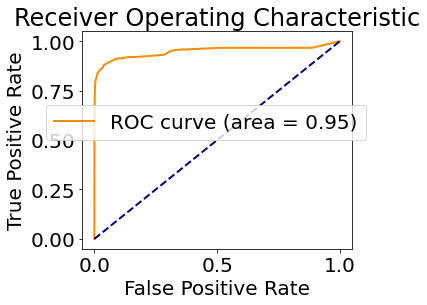

In [28]:
# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test_ori, DTC2_ori.predict_proba(X_test_ori_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

# Methods 1: Correcting the imbalance discovered by using resample

In [29]:
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 1842743, # to match majority class
                                 random_state=seed)  # reproducible results
df_minority_upsampled.shape

(1842743, 22)

In [30]:
# Combine majority class with upsampled minority class
total_upsampled = pd.concat([df_minority_upsampled, df_majority])
total_upsampled.shape

(3685486, 22)

In [31]:
x_cols = list(total_upsampled.columns)
x_cols.remove('is_fraud')
# x_cols

X = total_upsampled[x_cols]
Y = total_upsampled['is_fraud']
# X.info()

X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.3, random_state=seed)

### Scaling the x variables

In [32]:
sc= StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

### Feature Importances

In [33]:
logit_model= LogisticRegression(solver='liblinear')
logit_model.fit(X_train_std, Y_train)

LogisticRegression(solver='liblinear')

In [34]:
import numpy as np

# 假设Y_train已经通过train_test_split获取
unique, counts = np.unique(Y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

print("类别数量:", class_counts)

类别数量: {0: 1289678, 1: 1290162}


In [35]:
feature= pd.DataFrame()
feature['column']= X_train.columns
feature['importance']= logit_model.coef_[0]
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,4.026621
9,category_gas_transport,0.817853
11,category_grocery_pos,0.696021
17,category_personal_care,0.482282
14,category_kids_pets,0.463205
16,category_misc_pos,0.453623
10,category_grocery_net,0.391908
20,category_travel,0.376666
12,category_health_fitness,0.351456
8,category_food_dining,0.323299


In [36]:
DTC_model= DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)
DTC_model.fit(X_train_std, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [37]:
feature= pd.DataFrame()
feature['column']= X_train_ori.columns
feature['importance']= DTC_model.feature_importances_
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,0.779156
9,category_gas_transport,0.082251
10,category_grocery_net,0.028613
3,age,0.018481
20,category_travel,0.018451
13,category_home,0.017106
8,category_food_dining,0.015174
16,category_misc_pos,0.015158
2,city_pop,0.008479
17,category_personal_care,0.004169


## Logistic Regression

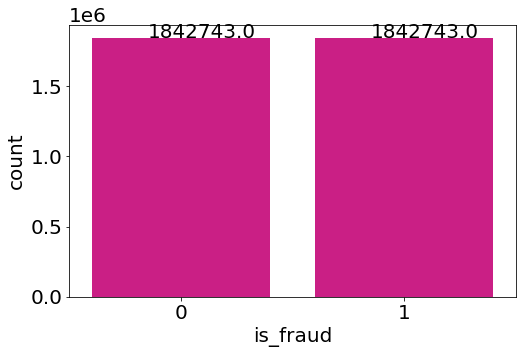

In [38]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x="is_fraud", data=total_upsampled,color=randomcolor())
for p in ax.patches:
     ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [39]:
Logit1=LogisticRegression(solver='liblinear')

Logit1.fit(X_train_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit1.score(X_train,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit1.score(X_test,Y_test)*100,2)),"%")

Y_pred=Logit1.predict(X_test_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  67.53 %
Score of the model with X-test and Y-test is :  67.52 %
 Mean absolute error is  0.17620648923796586
 Mean squared  error is  0.17620648923796586
 Median absolute error is  0.0
Accuracy is  82.38 %
F1 score:  82.28 %
Recall: 82.38 %


In [40]:
DTC1=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC1.fit(X_train_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(DTC1.score(X_train,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(DTC1.score(X_test,Y_test)*100,2)),"%")

Y_pred=DTC1.predict(X_test_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  46.91 %
Score of the model with X-test and Y-test is :  46.94 %
 Mean absolute error is  0.03537479446405088
 Mean squared  error is  0.03537479446405088
 Median absolute error is  0.0
Accuracy is  96.46 %
F1 score:  96.46 %
Recall: 96.46 %


## Method 1: Fine Tuning

In [41]:
X_train_new = X_train[[x for x in feature[feature["importance"]>0].column]]
X_test_new = X_test[[x for x in feature[feature["importance"]>0].column]]

checking p values & variance inflation factor

In [42]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [43]:
X_train_sm = sm.add_constant(X_train_new)
logm = sm.GLM(Y_train, X_train_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_fraud   No. Observations:              2579840
Model:                            GLM   Df Residuals:                  2579820
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.4688e+05
Date:                Wed, 10 Apr 2024   Deviance:                   1.8938e+06
Time:                        08:08:31   Pearson chi2:                 1.11e+18
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4791
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     355.8763      7.295     48.783      0.000     341.578     370.175
amt                         0.0103   1.74e-05    592.388      0.000       0.010       0.010
category_gas_transport      3.4035      0.010    335.658      0.000       3.384       3.423
category_grocery_net        2.9966      0.012    242.827      0.000       2.972       3.021
age                         0.0021      0.000     20.692      0.000       0.002       0.002
category_travel             3.0256      0.013    224.734      0.000       2.999       3.052
category_home               1.5332      0.011    144.639      0.000       1.512       1.554
category_food_dining        2.1120      0.011    186.950      0.000       2.090       2.134
category_misc_pos           2.6896      0.012    231.182      0.000       2.667       2.712
city_pop                -9.782e-08   6.16e-09    -15.887      0.000    -1.1e-07   -8.58e-08
category_personal_care      2.7652      0.011    249.187      0.000       2.743       2.787
category_kids_pets          2.5192      0.011    231.972      0.000       2.498       2.540
category_health_fitness     2.2961      0.012    195.774      0.000       2.273       2.319
category_shopping_net      -1.3053      0.017    -77.286      0.000      -1.338      -1.272
trans_month                -0.0695      0.001   -133.014      0.000      -0.071      -0.069
category_grocery_pos        2.5127      0.008    299.541      0.000       2.496       2.529
longitudinal_distance      -0.0208      0.006     -3.344      0.001      -0.033      -0.009
gender                     -0.1694      0.004    -46.127      0.000      -0.177      -0.162
trans_year                 -0.1780      0.004    -49.280      0.000      -0.185      -0.171
latitudinal_distance        0.0533      0.006      8.509      0.000       0.041       0.066
===========================================================================================
"""

In [44]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,trans_year,24.85
3,age,7.91
13,trans_month,4.82
18,latitudinal_distance,4.04
15,longitudinal_distance,3.98
0,amt,3.10
16,gender,1.93
12,category_shopping_net,1.83
14,category_grocery_pos,1.80
1,category_gas_transport,1.61


since all columns have VIF < 5 , we'll continue with all columns

In [45]:
#x_train_vif_adj = X_train_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_train_vif_adj = X_train_new
#x_test_vif_adj = X_test_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_test_vif_adj = X_test_new


Scaling the new test and train sets

In [46]:
sc= StandardScaler()
X_train_vif_adj_std=sc.fit_transform(x_train_vif_adj)
X_test_vif_adj_std = sc.fit_transform(x_test_vif_adj)

Training a new Logistic Regression Model to reflect the changes-

In [47]:
Logit2=LogisticRegression(solver='liblinear')

Logit2.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2.score(X_test_vif_adj_std,Y_test)*100,2)),"%")

Y_pred=Logit2.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  82.25 %
Score of the model with X-test and Y-test is :  82.24 %
 Mean absolute error is  0.1775939134225602
 Mean squared  error is  0.1775939134225602
 Median absolute error is  0.0
Accuracy is  82.24 %
F1 score:  82.14 %
Recall: 82.24 %


In [48]:
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[412746 139835]
 [ 56521 496544]]
Outcome values : 
 412746 139835 56521 496544
Classification report : 
               precision    recall  f1-score   support

           1       0.88      0.75      0.81    552581
           0       0.78      0.90      0.83    553065

    accuracy                           0.82   1105646
   macro avg       0.83      0.82      0.82   1105646
weighted avg       0.83      0.82      0.82   1105646



In [49]:
m1_lg_Recall = recall_score(Y_test, Y_pred, average='macro')
m1_lg_Precision = precision_score(Y_test, Y_pred, average='macro')
m1_lg_f1 = f1_score(Y_test, Y_pred, average='macro')
m1_lg_accuracy = accuracy_score(Y_test, Y_pred)
m1_lg_mae = mean_absolute_error(Y_test,Y_pred)
m1_lg_mse = mean_squared_error(Y_test,Y_pred)

m1_ndf = [(m1_lg_Recall, m1_lg_Precision, m1_lg_f1, m1_lg_accuracy,m1_lg_mae,m1_lg_mse)]
m1_lg_score = pd.DataFrame(data = m1_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m1_lg_score.insert(1, 'Logistic Regression with', 'Resampling')
m1_lg_score

,Recall,Logistic Regression with,Precision,F1 Score,Accuracy,MAE,MSE
0,0.822373,Resampling,0.82991,0.82138,0.822406,0.177594,0.177594


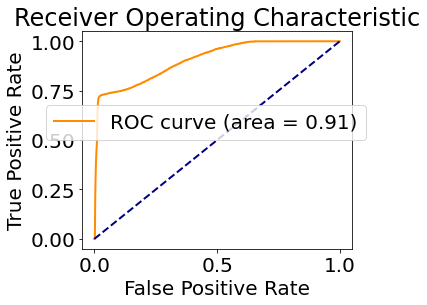

In [50]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, Logit2.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

## Decision Tree

In [51]:
DTC2=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC2.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(DTC2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(DTC2.score(X_test_vif_adj_std,Y_test)*100,2)),"%")

Y_pred=DTC2.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  96.88 %
Score of the model with X-test and Y-test is :  96.47 %
 Mean absolute error is  0.0353241453412756
 Mean squared  error is  0.0353241453412756
 Median absolute error is  0.0
Accuracy is  96.47 %
F1 score:  96.47 %
Recall: 96.47 %


In [52]:
m1_dt_Recall = recall_score(Y_test, Y_pred, average='macro')
m1_dt_Precision = precision_score(Y_test, Y_pred, average='macro')
m1_dt_f1 = f1_score(Y_test, Y_pred, average='macro')
m1_dt_accuracy = accuracy_score(Y_test, Y_pred)
m1_dt_mae = mean_absolute_error(Y_test,Y_pred)
m1_dt_mse = mean_squared_error(Y_test,Y_pred)

m1_ndf = [(m1_dt_Recall, m1_dt_Precision, m1_dt_f1, m1_dt_accuracy,m1_dt_mae,m1_dt_mse)]
m1_dt_score = pd.DataFrame(data = m1_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m1_dt_score.insert(0, 'Decision Tree with', 'Resampling')
m1_dt_score

,Decision Tree with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,Resampling,0.964681,0.964978,0.96467,0.964676,0.035324,0.035324


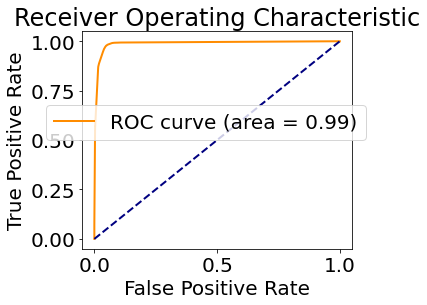

In [53]:
# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, DTC2.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

In [54]:
# plot_roc_curve(Logit2, X_test_vif_adj_std, Y_test)
# plt.show()

# Method 2: Random Resampling Imbalanced Datasets

In [55]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=seed)

In [56]:
x_train_ori_col = list(total.columns)
x_train_ori_col.remove('is_fraud')
x_train_ori_col

X_ori = total[x_train_ori_col]
Y_ori = total['is_fraud']
# print(X_ori.info())

print('BEFORE...')
print('Genuine:', Y_ori.value_counts()[0], '/', round(Y_ori.value_counts()[0]/len(Y_ori) * 100,2), '% of the dataset')
print('Frauds:', Y_ori.value_counts()[1], '/',round(Y_ori.value_counts()[1]/len(Y_ori) * 100,2), '% of the dataset')

print('AFTER...')
X_m2_over, Y_m2_over = ros.fit_resample(X_ori, Y_ori)
print('Genuine:', Y_m2_over.value_counts()[0], '/', round(Y_m2_over.value_counts()[0]/len(Y_m2_over) * 100,2), '% of the dataset')
print('Frauds:', Y_m2_over.value_counts()[1], '/',round(Y_m2_over.value_counts()[1]/len(Y_m2_over) * 100,2), '% of the dataset')

X_train, X_test, Y_train, Y_test = train_test_split(
 X_m2_over, Y_m2_over, test_size=0.3, random_state=seed)
sc= StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

BEFORE...
Genuine: 1842743 / 99.48 % of the dataset
Frauds: 9651 / 0.52 % of the dataset
AFTER...
Genuine: 1842743 / 50.0 % of the dataset
Frauds: 1842743 / 50.0 % of the dataset


### Feature Importance Exploration

In [57]:
logit_m2_model= LogisticRegression(solver='liblinear')
logit_m2_model.fit(X_train_std, Y_train)

LogisticRegression(solver='liblinear')

In [58]:
feature_m2= pd.DataFrame()
feature_m2['column']= X_train_ori.columns
feature_m2['importance']= logit_m2_model.coef_[0]
feature_m2.sort_values('importance', ascending=False, inplace=True)
feature_m2

,column,importance
0,amt,4.031544
9,category_gas_transport,0.822940
11,category_grocery_pos,0.699251
17,category_personal_care,0.484183
14,category_kids_pets,0.466126
16,category_misc_pos,0.457256
10,category_grocery_net,0.396209
20,category_travel,0.377081
12,category_health_fitness,0.356364
8,category_food_dining,0.326353


In [59]:
DTC_m2_model= DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)
DTC_m2_model.fit(X_train_std, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [60]:
feature= pd.DataFrame()
feature['column']= X_train_ori.columns
feature['importance']= DTC_m2_model.feature_importances_
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,0.778568
9,category_gas_transport,0.082346
10,category_grocery_net,0.028904
3,age,0.018724
20,category_travel,0.018319
13,category_home,0.017045
8,category_food_dining,0.015305
16,category_misc_pos,0.015202
2,city_pop,0.008689
17,category_personal_care,0.004118


## Train

In [61]:
Logit1_m2=LogisticRegression(solver='liblinear')

Logit1_m2.fit(X_train_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit1_m2.score(X_train,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit1_m2.score(X_test,Y_test)*100,2)),"%")

Y_pred_m2=Logit1_m2.predict(X_test_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred_m2)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred_m2))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred_m2)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred_m2)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred_m2, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred_m2, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  67.71 %
Score of the model with X-test and Y-test is :  67.65 %
 Mean absolute error is  0.17588360108027343
 Mean squared  error is  0.17588360108027343
 Median absolute error is  0.0
Accuracy is  82.41 %
F1 score:  82.32 %
Recall: 82.41 %


In [62]:
X_train_new=X_train[[x for x in feature_m2[feature_m2["importance"]>0].column]]
X_test_new=X_test[[x for x in feature_m2[feature_m2["importance"]>0].column]]

In [63]:
X_train_m2_sm = sm.add_constant(X_train_new)
logm = sm.GLM(Y_train, X_train_m2_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_fraud   No. Observations:              2579840
Model:                            GLM   Df Residuals:                  2579826
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.6116e+05
Date:                Wed, 10 Apr 2024   Deviance:                   1.9223e+06
Time:                        08:12:42   Pearson chi2:                 1.05e+18
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4733
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.3080      0.011   -393.979      0.000      -4.329      -4.287
amt                         0.0101   1.68e-05    599.988      0.000       0.010       0.010
category_gas_transport      3.5444      0.010    358.861      0.000       3.525       3.564
category_grocery_pos        2.6723      0.008    336.409      0.000       2.657       2.688
category_personal_care      2.9111      0.011    268.449      0.000       2.890       2.932
category_kids_pets          2.6726      0.011    252.016      0.000       2.652       2.693
category_misc_pos           2.8295      0.011    248.581      0.000       2.807       2.852
category_grocery_net        3.1367      0.012    259.737      0.000       3.113       3.160
category_travel             3.1634      0.013    238.667      0.000       3.137       3.189
category_health_fitness     2.4507      0.011    213.627      0.000       2.428       2.473
category_food_dining        2.2672      0.011    205.646      0.000       2.246       2.289
category_home               1.7032      0.010    165.984      0.000       1.683       1.723
age                         0.0017      0.000     17.034      0.000       0.002       0.002
latitudinal_distance        0.0449      0.006      7.238      0.000       0.033       0.057
===========================================================================================
"""

In [64]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,age,4.73
12,latitudinal_distance,3.30
0,amt,2.16
2,category_grocery_pos,1.43
1,category_gas_transport,1.36
4,category_kids_pets,1.21
3,category_personal_care,1.19
10,category_home,1.19
8,category_health_fitness,1.15
9,category_food_dining,1.15


In [65]:
# since all columns have VIF < 5 , we'll continue with all columns
#x_train_vif_adj = X_train_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_train_vif_adj = X_train_new
#x_test_vif_adj = X_test_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_test_vif_adj = X_test_new

In [66]:
sc= StandardScaler()
X_train_vif_adj_std=sc.fit_transform(x_train_vif_adj)
X_test_vif_adj_std = sc.fit_transform(x_test_vif_adj)

In [67]:
Logit2_m2=LogisticRegression(solver='liblinear',random_state=seed)

Logit2_m2.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2_m2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2_m2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")

Y_pred=Logit2_m2.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  82.23 %
Score of the model with X-test and Y-test is :  82.23 %
 Mean absolute error is  0.17567919569193033
 Mean squared  error is  0.17567919569193033
 Median absolute error is  0.0
Accuracy is  82.43 %
F1 score:  82.32 %
Recall: 82.43 %


In [68]:
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[410975 142121]
 [ 52118 500432]]
Outcome values : 
 410975 142121 52118 500432
Classification report : 
               precision    recall  f1-score   support

           1       0.89      0.74      0.81    553096
           0       0.78      0.91      0.84    552550

    accuracy                           0.82   1105646
   macro avg       0.83      0.82      0.82   1105646
weighted avg       0.83      0.82      0.82   1105646



In [69]:
m2_lg_Recall = recall_score(Y_test, Y_pred, average='macro')
m2_lg_Precision = precision_score(Y_test, Y_pred, average='macro')
m2_lg_f1 = f1_score(Y_test, Y_pred, average='macro')
m2_lg_accuracy = accuracy_score(Y_test, Y_pred)
m2_lg_mae = mean_absolute_error(Y_test,Y_pred)
m2_lg_mse = mean_squared_error(Y_test,Y_pred)

m2_ndf = [(m2_lg_Recall, m2_lg_Precision, m2_lg_f1, m2_lg_accuracy,m2_lg_mae,m2_lg_mse)]
m2_lg_score = pd.DataFrame(data = m2_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m2_lg_score.insert(0, 'Logistic Regression with', 'Random resampling')
m2_lg_score

,Logistic Regression with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,Random resampling,0.824361,0.833137,0.823163,0.824321,0.175679,0.175679


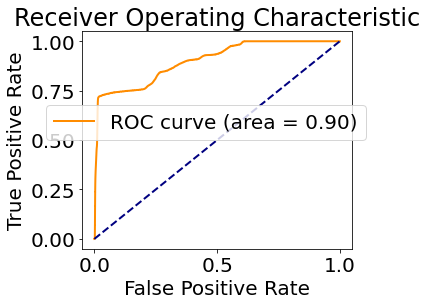

In [70]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, Logit2_m2.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

## Decision Tree

In [71]:
DTC2_m2=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC2_m2.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2_m2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2_m2.score(X_train_vif_adj_std,Y_train)*100,2)),"%")

Y_pred=DTC2_m2.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  82.23 %
Score of the model with X-test and Y-test is :  82.23 %
 Mean absolute error is  0.04496466319237803
 Mean squared  error is  0.04496466319237803
 Median absolute error is  0.0
Accuracy is  95.5 %
F1 score:  95.5 %
Recall: 95.5 %


In [72]:
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[529595  23501]
 [ 26214 526336]]
Outcome values : 
 529595 23501 26214 526336
Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.96      0.96    553096
           0       0.96      0.95      0.95    552550

    accuracy                           0.96   1105646
   macro avg       0.96      0.96      0.96   1105646
weighted avg       0.96      0.96      0.96   1105646



In [73]:
m2_dt_Recall = recall_score(Y_test, Y_pred, average='macro')
m2_dt_Precision = precision_score(Y_test, Y_pred, average='macro')
m2_dt_f1 = f1_score(Y_test, Y_pred, average='macro')
m2_dt_accuracy = accuracy_score(Y_test, Y_pred)
m2_dt_mae = mean_absolute_error(Y_test,Y_pred)
m2_dt_mse = mean_squared_error(Y_test,Y_pred)

m2_ndf = [(m2_dt_Recall, m2_dt_Precision, m2_dt_f1, m2_dt_accuracy,m2_dt_mae,m2_dt_mse)]
m2_dt_score = pd.DataFrame(data = m2_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m2_dt_score.insert(0, 'Decision Tree with', 'Random resampling')
m2_dt_score

,Decision Tree with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,Random resampling,0.955034,0.955047,0.955035,0.955035,0.044965,0.044965


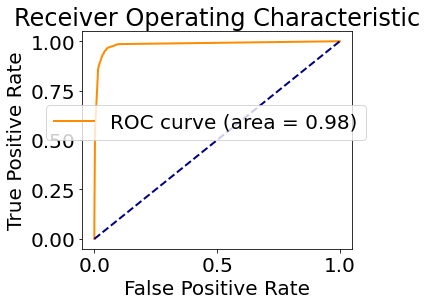

In [74]:
# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, DTC2_m2.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

In [75]:
# plot_roc_curve(Logit2_m2, X_test_vif_adj_std, Y_test)
# plt.show()

# Method 3: SMOTE (Synthetic Minority Oversampling Technique)

In [76]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=seed)

In [77]:
x_train_ori_col = list(total.columns)
x_train_ori_col.remove('is_fraud')
x_train_ori_col

X_ori = total[x_train_ori_col]
Y_ori = total['is_fraud']
# print(X_ori.info())

print('BEFORE...')
print('Genuine:', Y_ori.value_counts()[0], '/', round(Y_ori.value_counts()[0]/len(Y_ori) * 100,2), '% of the dataset')
print('Frauds:', Y_ori.value_counts()[1], '/',round(Y_ori.value_counts()[1]/len(Y_ori) * 100,2), '% of the dataset')

print('AFTER...')
X_m3_over, Y_m3_over = smote.fit_resample(X_ori, Y_ori)
print('Genuine:', Y_m3_over.value_counts()[0], '/', round(Y_m3_over.value_counts()[0]/len(Y_m3_over) * 100,2), '% of the dataset')
print('Frauds:', Y_m3_over.value_counts()[1], '/',round(Y_m3_over.value_counts()[1]/len(Y_m3_over) * 100,2), '% of the dataset')

X_train, X_test, Y_train, Y_test = train_test_split(
 X_m3_over, Y_m3_over, test_size=0.3, random_state=seed)
sc= StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

BEFORE...
Genuine: 1842743 / 99.48 % of the dataset
Frauds: 9651 / 0.52 % of the dataset
AFTER...
Genuine: 1842743 / 50.0 % of the dataset
Frauds: 1842743 / 50.0 % of the dataset


### Feature Importance Exploration

In [78]:
logit_m3_model= LogisticRegression(solver='liblinear')
logit_m3_model.fit(X_train_std, Y_train)

LogisticRegression(solver='liblinear')

In [79]:
feature_m3= pd.DataFrame()
feature_m3['column']= X_train_ori.columns
feature_m3['importance']= logit_m3_model.coef_[0]
feature_m3.sort_values('importance', ascending=False, inplace=True)
feature_m3

,column,importance
0,amt,3.863550
3,age,0.056190
6,latitudinal_distance,0.014187
7,longitudinal_distance,-0.019520
2,city_pop,-0.102607
1,gender,-0.296849
4,trans_month,-0.327751
5,trans_year,-0.371279
10,category_grocery_net,-0.485402
9,category_gas_transport,-0.527947


In [80]:
DTC_m3_model= DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)
DTC_m3_model.fit(X_train_std, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [81]:
feature= pd.DataFrame()
feature['column']= X_train_ori.columns
feature['importance']= DTC_m3_model.feature_importances_
feature.sort_values('importance', ascending=False, inplace=True)
feature

,column,importance
0,amt,0.835412
9,category_gas_transport,0.025277
8,category_food_dining,0.022206
13,category_home,0.018069
19,category_shopping_pos,0.014844
18,category_shopping_net,0.012891
2,city_pop,0.012579
15,category_misc_net,0.011405
17,category_personal_care,0.011098
20,category_travel,0.009765


### Train

In [82]:
Logit1_m3=LogisticRegression(solver='liblinear')

Logit1_m3.fit(X_train_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit1_m3.score(X_train,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit1_m3.score(X_test,Y_test)*100,2)),"%")

Y_pred=Logit1_m3.predict(X_test_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  75.23 %
Score of the model with X-test and Y-test is :  75.23 %
 Mean absolute error is  0.09593848302259493
 Mean squared  error is  0.09593848302259493
 Median absolute error is  0.0
Accuracy is  90.41 %
F1 score:  90.41 %
Recall: 90.41 %


In [83]:
X_train_new=X_train[[x for x in feature_m3[feature_m3["importance"]>0].column]]
X_test_new=X_test[[x for x in feature_m3[feature_m3["importance"]>0].column]]

In [84]:
X_train_m3_sm = sm.add_constant(X_train_new)
logm = sm.GLM(Y_train, X_train_m3_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_fraud   No. Observations:              2579840
Model:                            GLM   Df Residuals:                  2579836
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0871e+06
Date:                Wed, 10 Apr 2024   Deviance:                   2.1743e+06
Time:                        08:15:48   Pearson chi2:                 6.93e+17
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4193
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7623      0.006   -300.507      0.000      -1.774      -1.751
amt                      0.0080   1.27e-05    631.718      0.000       0.008       0.008
age                      0.0042   9.63e-05     44.028      0.000       0.004       0.004
latitudinal_distance     0.0382      0.006      6.206      0.000       0.026       0.050
========================================================================================
"""

In [85]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,age,3.58
2,latitudinal_distance,3.29
0,amt,1.59


In [86]:
# since all columns have VIF < 5 , we'll continue with all columns
#x_train_vif_adj = X_train_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_train_vif_adj = X_train_new
#x_test_vif_adj = X_test_new[[x for x in list(vif[vif['VIF']<=5]['Features'])]]
x_test_vif_adj = X_test_new

In [87]:
sc= StandardScaler()
X_train_vif_adj_std=sc.fit_transform(x_train_vif_adj)
X_test_vif_adj_std = sc.fit_transform(x_test_vif_adj)

In [88]:
Logit2_m3=LogisticRegression(solver='liblinear',random_state=seed)

Logit2_m3.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(Logit2_m3.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(Logit2_m3.score(X_train_vif_adj_std,Y_train)*100,2)),"%")

Y_pred=Logit2_m3.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='weighted') * 100, 2), "%")

Score of the model with X-train and Y-train is :  85.61 %
Score of the model with X-test and Y-test is :  85.61 %
 Mean absolute error is  0.14387064214043194
 Mean squared  error is  0.14387064214043194
 Median absolute error is  0.0
Accuracy is  85.61 %
F1 score:  85.48 %
Recall: 85.61 %


In [89]:
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[419567 133529]
 [ 25541 527009]]
Outcome values : 
 419567 133529 25541 527009
Classification report : 
               precision    recall  f1-score   support

           1       0.94      0.76      0.84    553096
           0       0.80      0.95      0.87    552550

    accuracy                           0.86   1105646
   macro avg       0.87      0.86      0.85   1105646
weighted avg       0.87      0.86      0.85   1105646



In [90]:
m3_lg_Recall = recall_score(Y_test, Y_pred, average='macro')
m3_lg_Precision = precision_score(Y_test, Y_pred, average='macro')
m3_lg_f1 = f1_score(Y_test, Y_pred, average='macro')
m3_lg_accuracy = accuracy_score(Y_test, Y_pred)
m3_lg_mae = mean_absolute_error(Y_test,Y_pred)
m3_lg_mse = mean_squared_error(Y_test,Y_pred)

m3_ndf = [(m3_lg_Recall, m3_lg_Precision, m3_lg_f1, m3_lg_accuracy,m3_lg_mae,m3_lg_mse)]
m3_lg_score = pd.DataFrame(data = m3_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m3_lg_score.insert(0, 'Logistic Regression with', 'SMOTE')
m3_lg_score

,Logistic Regression with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,SMOTE,0.856178,0.870233,0.854758,0.856129,0.143871,0.143871


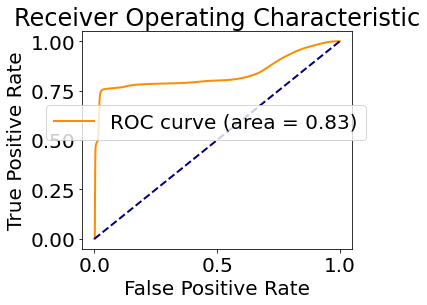

In [91]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, Logit2_m3.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

In [92]:
final_result_report = pd.concat([m0_lg_score, m1_lg_score, m2_lg_score, m3_lg_score], ignore_index=True, sort=False)
final_result_report.sort_values(by=['Recall'], ascending=False)

,Logistic Regression with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
3,SMOTE,0.856178,0.870233,0.854758,0.856129,0.143871,0.143871
2,Random resampling,0.824361,0.833137,0.823163,0.824321,0.175679,0.175679
1,Resampling,0.822373,0.829910,0.821380,0.822406,0.177594,0.177594
0,No Oversampling,0.499766,0.497417,0.498588,0.994369,0.005631,0.005631


In [93]:
DTC2_m3=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=10, min_samples_leaf=5)

DTC2_m3.fit(X_train_vif_adj_std,Y_train)

print("Score of the model with X-train and Y-train is : ", str(round(DTC2_m3.score(X_train_vif_adj_std,Y_train)*100,2)),"%")
print("Score of the model with X-test and Y-test is : ", str(round(DTC2_m3.score(X_train_vif_adj_std,Y_train)*100,2)),"%")

Y_pred=DTC2_m3.predict(X_test_vif_adj_std)

print( " Mean absolute error is ",( mean_absolute_error(Y_test,Y_pred)))
print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
print("Accuracy is " , round(accuracy_score(Y_test,Y_pred)*100,2),"%")
print("F1 score: ", round(f1_score(Y_test, Y_pred, average='macro')*100,2),"%")
print("Recall:", round(recall_score(Y_test, Y_pred, average='macro') * 100, 2), "%")

Score of the model with X-train and Y-train is :  89.77 %
Score of the model with X-test and Y-test is :  89.77 %
 Mean absolute error is  0.12118254848296833
 Mean squared  error is  0.12118254848296833
 Median absolute error is  0.0
Accuracy is  87.88 %
F1 score:  87.88 %
Recall: 87.88 %


In [94]:
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)


tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)


matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[486639  66457]
 [ 67528 485022]]
Outcome values : 
 486639 66457 67528 485022
Classification report : 
               precision    recall  f1-score   support

           1       0.88      0.88      0.88    553096
           0       0.88      0.88      0.88    552550

    accuracy                           0.88   1105646
   macro avg       0.88      0.88      0.88   1105646
weighted avg       0.88      0.88      0.88   1105646



In [95]:
m3_dt_Recall = recall_score(Y_test, Y_pred, average='macro')
m3_dt_Precision = precision_score(Y_test, Y_pred, average='macro')
m3_dt_f1 = f1_score(Y_test, Y_pred, average='macro')
m3_dt_accuracy = accuracy_score(Y_test, Y_pred)
m3_dt_mae = mean_absolute_error(Y_test,Y_pred)
m3_dt_mse = mean_squared_error(Y_test,Y_pred)

m3_ndf = [(m3_dt_Recall, m3_dt_Precision, m3_dt_f1, m3_dt_accuracy,m3_dt_mae,m3_dt_mse)]
m3_dt_score = pd.DataFrame(data = m3_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy','MAE','MSE'])
m3_dt_score.insert(0, 'Decision Tree with', 'SMOTE')
m3_dt_score

,Decision Tree with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
0,SMOTE,0.878817,0.878819,0.878817,0.878817,0.121183,0.121183


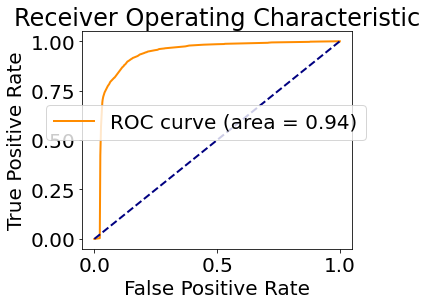

In [96]:
# 假设你已经有了预测结果和真实标签，计算ROC曲线的坐标
fpr, tpr, thresholds = roc_curve(Y_test, DTC2_m3.predict_proba(X_test_vif_adj_std)[:,1])
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# 添加对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设定坐标轴标签和图的标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# 将图例放置在图表外的右侧
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# 调整图表边界，为图例腾出空间
plt.subplots_adjust(right=0.75)

# 展示图表
plt.show()

In [97]:
final_result_report = pd.concat([m0_dt_score, m1_dt_score, m2_dt_score, m3_dt_score], ignore_index=True, sort=False)
final_result_report.sort_values(by=['Recall'], ascending=False)

,Decision Tree with,Recall,Precision,F1 Score,Accuracy,MAE,MSE
1,Resampling,0.964681,0.964978,0.964670,0.964676,0.035324,0.035324
2,Random resampling,0.955034,0.955047,0.955035,0.955035,0.044965,0.044965
3,SMOTE,0.878817,0.878819,0.878817,0.878817,0.121183,0.121183
0,No Oversampling,0.827924,0.890514,0.856461,0.997286,0.002714,0.002714


In [98]:
# plot_roc_curve(Logit2_m3, X_test_vif_adj_std, Y_test)
# plt.show()

# Method 4: Undersampling using Tomek Links (Future) TOO SOLW

In [99]:
from imblearn.under_sampling import TomekLinks

# define the undersampling method
tomekU = TomekLinks()

In [100]:
x_train_ori_col = list(total.columns)
x_train_ori_col.remove('is_fraud')
x_train_ori_col

X_ori = total[x_train_ori_col]
Y_ori = total['is_fraud']
# print(X_ori.info())

print('BEFORE...')
print('Genuine:', Y_ori.value_counts()[0], '/', round(Y_ori.value_counts()[0]/len(Y_ori) * 100,2), '% of the dataset')
print('Frauds:', Y_ori.value_counts()[1], '/',round(Y_ori.value_counts()[1]/len(Y_ori) * 100,2), '% of the dataset')

print('AFTER...')
X_underT, y_underT = tomekU.fit_resample(X_ori, Y_ori)
print('Genuine:', y_underT.value_counts()[0], '/', round(y_underT.value_counts()[0]/len(y_underT) * 100,2), '% of the dataset')
print('Frauds:', y_underT.value_counts()[1], '/',round(y_underT.value_counts()[1]/len(y_underT) * 100,2), '% of the dataset')

BEFORE...
Genuine: 1842743 / 99.48 % of the dataset
Frauds: 9651 / 0.52 % of the dataset
AFTER...


KeyboardInterrupt: 

# Method 5: Combining SMOTE and Tomek Links OR BorderlineSMOTE (Future) TOO SLOW!


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
import logging

# 配置日志记录器
logging.basicConfig(level=logging.INFO)

# 假设 X_ori 和 Y_ori 是您的原始特征和目标变量
Borderline_smote = BorderlineSMOTE(random_state=seed)

from imblearn.combine import SMOTETomek

# 假设 X_ori 和 Y_ori 表示您的原始特征和目标变量
smotetomek = SMOTETomek(random_state=seed)
X_resampled, Y_resampled = smotetomek.fit_resample(X_ori, Y_ori)



In [ ]:
x_train_ori_col = list(total.columns)
x_train_ori_col.remove('is_fraud')
x_train_ori_col

X_ori = total[x_train_ori_col]
Y_ori = total['is_fraud']
# print(X_ori.info())

print('BEFORE...')
print('Genuine:', Y_ori.value_counts()[0], '/', round(Y_ori.value_counts()[0]/len(Y_ori) * 100,2), '% of the dataset')
print('Frauds:', Y_ori.value_counts()[1], '/',round(Y_ori.value_counts()[1]/len(Y_ori) * 100,2), '% of the dataset')

print('AFTER...')
X_m5_over, Y_m5_over = Borderline_smote.fit_resample(X_ori, Y_ori)
print('Genuine:', Y_m5_over.value_counts()[0], '/', round(Y_m5_over.value_counts()[0]/len(Y_m5_over) * 100,2), '% of the dataset')
print('Frauds:', Y_m5_over.value_counts()[1], '/',round(Y_m5_over.value_counts()[1]/len(Y_m5_over) * 100,2), '% of the dataset')

X_train, X_test, Y_train, Y_test = train_test_split(
 Y_m5_over, Y_m5_over, test_size=0.3, random_state=seed)
sc= StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

## Decision Tree

In [ ]:
# dtc = DecisionTreeClassifier()
# dtc.fit(X_train,Y_train)

### Feature Importances using Decision Tree

In [ ]:
# importance = dtc.feature_importances_
# for i,v in enumerate(importance):
#     print(X_train.columns[int(i)],"- ",v)
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

In [ ]:
# print("Score the X-train with Y-train is : ", dtc.score(X_train,Y_train))
# print("Score the X-test  with Y-test  is : ", dtc.score(X_test,Y_test))

# Y_pred=dtc.predict(X_test)

# print( " Mean absolute error is ", mean_absolute_error(Y_test,Y_pred))
# print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
# print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
# print("Accuracy score " , accuracy_score(Y_test,Y_pred))
# print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

Perfect score on training set indicates overfitting. Using hyperparameter tuning.
### Hyperparameter Tuning

In [ ]:
# #Normal Randomised Search takes too much time to execute on a dataset this large.
# """dtc1 = DecisionTreeClassifier()


# params_dtc = {  
#     "splitter":["best"],
#     'max_depth': [10, 20, 50, 100, 200],
#     'min_samples_leaf': [10, 20, 50, 100, 200],
#     'min_samples_split' : [10, 20, 50, 100, 200],
#     'criterion': ["gini", "entropy"]
# }
# random_search=RandomizedSearchCV(estimator=dtc1,param_distributions = params_dtc, scoring = 'f1',cv=5,n_iter=100)
# random_search.fit(X_train,Y_train)"""

Since dataset is very large(close to 1.8 million rows originally and even more after treating for unbalanced condition),
we will use halving randomized search cross validation which is an experimental variant of the randomised search, much  faster compared to either randomised search or grid search cross validation.


In [ ]:
# dtc1 = DecisionTreeClassifier()

# params_dtc = {
#     'max_depth': [10, 20, 50, 100, 200],
#     'min_samples_leaf': [10, 20, 50, 100, 200],
#     'min_samples_split' : [10, 20, 50, 100, 200],
#     'criterion': ["gini", "entropy"]
# } 

# halving_random_search=HalvingRandomSearchCV(estimator=dtc1,param_distributions = params_dtc,cv=5)
# halving_random_search.fit(X_train,Y_train)
# print(halving_random_search.best_params_)

In [ ]:
# print(halving_random_search.best_params_)

In [ ]:
# dtc2 = DecisionTreeClassifier(min_samples_split= 100, min_samples_leaf= 20, max_depth= 200, criterion= 'gini')
# dtc2.fit(X_train,Y_train)

In [ ]:
# print("Score the X-train with Y-train is : ", dtc2.score(X_train,Y_train))
# print("Score the X-test  with Y-test  is : ", dtc2.score(X_test,Y_test))

# Y_pred=dtc2.predict(X_test)

# print( " Mean absolute error is ", mean_absolute_error(Y_test,Y_pred))
# print(" Mean squared  error is " , mean_squared_error(Y_test,Y_pred))
# print(" Median absolute error is " ,median_absolute_error(Y_test,Y_pred)) 
# print("Accuracy score " , accuracy_score(Y_test,Y_pred))
# print("F1 score: ", round(f1_score(Y_test, Y_pred, average='weighted')*100,2),"%")

In [ ]:
# matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
# print('Confusion matrix : \n',matrix)


# tp, fn, fp, tn = confusion_matrix(Y_test,Y_pred,labels=[1,0]).reshape(-1)
# print('Outcome values : \n', tp, fn, fp, tn)


# matrix = classification_report(Y_test,Y_pred,labels=[1,0])
# print('Classification report : \n',matrix)

In [ ]:
# plot_roc_curve(dtc2, X_test, Y_test)
# plt.show()

In accordance with the confusion matrix, the roc curve is almost perfect.